In [1]:
import pandas as pd
from data_cleaning.calc_fpoints import calc_fpoints_batter, calc_fpoints_pitcher
from data_cleaning.combine_dfs import combine_metrics_stats, pitch_combine_metrics_stats
from plotting.plots import plot_top_x_corr
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE, SelectKBest, f_regression, SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb
import warnings

import lime

import lime.lime_tabular


In [2]:
# Reading in data and calculating fantasy points
# Minimum PA of 50 for both datasets
pitcher_data = pd.read_csv("data/pitcher_stats_base.csv")
pitcher_fpoints = calc_fpoints_pitcher(pitcher_data, output = False)
pitcher_fpoints.head()


Name  year  age     IP    H    K  BB  ER  S   W   L  Hold  \
0   Colon, Bartolo  2015   42  194.2  217  136  24  90  0  14  13     0   
1  Hawkins, LaTroy  2015   42   38.2   44   34   7  14  3   3   1     7   
2      Wolf, Randy  2015   38   34.2   46   28  15  24  0   0   5     1   
3   Marquis, Jason  2015   36   47.1   64   37  14  34  0   3   4     0   
4    Burnett, A.J.  2015   38  164.0  174  143  49  58  0   9   7     0   

   Fpoints  Fpoints_IP  
0    297.6    1.532441  
1     69.6    1.821990  
2     21.6    0.631579  
3     32.3    0.685775  
4    296.0    1.804878

In [3]:
all_fpoints_24 = pitcher_fpoints[pitcher_fpoints['year'] == 2024][["Name", "Fpoints_IP"]]

In [4]:
pitcher_metrics = pd.read_csv("data/pitcher_metrics.csv")
pitcher_combined = pitch_combine_metrics_stats(pitcher_fpoints, pitcher_metrics, save = False)
name_split = pitcher_combined['Name'].str.split(', ', expand=True)
# Combine first and last names in the desired format
pitcher_combined['Name'] = name_split[1] + ' ' + name_split[0]
pitcher_combined.head()

Name  Fpoints_IP  year  age  k_percent  bb_percent    xba   xslg  \
0   Bartolo Colon    1.692469  2016   43       16.7         2.9  0.268  0.427   
1    Jason Grilli    2.169492  2016   39       32.1         7.1  0.221  0.359   
2  Joaquín Benoit    2.187500  2016   38       24.8         9.1  0.194  0.328   
3    Matt Belisle    2.217391  2016   36       16.8        10.1  0.238  0.320   
4     CC Sabathia    1.655134  2016   35       18.9         6.9  0.253  0.378   

    woba  xwoba  ...  breaking_avg_break_z_induced  breaking_avg_break  \
0  0.316  0.314  ...                           3.3                 6.5   
1  0.269  0.275  ...                          -3.0                12.7   
2  0.243  0.271  ...                           4.8                 6.5   
3  0.306  0.297  ...                           0.6                 8.8   
4  0.343  0.304  ...                          -0.1                11.8   

   breaking_range_speed  n_offspeed_formatted  offspeed_avg_speed  \
0                   1.8                   7.4                82.6   
1                   1.2                   0.2                86.5   
2                   1.8                  34.4                84.7   
3                   5.0                   3.1                86.4   
4                   1.5                  14.0                83.9   

   offspeed_avg_spin  offspeed_avg_break_x  offspeed_avg_break_z  \
0             1727.0                 -13.2                 -32.0   
1             2257.0                 -15.3                 -26.5   
2             1434.0                 -12.4                 -36.0   
3             1838.0                  -5.9                 -33.6   
4             1950.0                  11.1                 -30.1   

   offspeed_avg_break_z_induced  offspeed_avg_break  
0                           9.0                16.4  
1                          10.8                18.7  
2                           2.8                13.1  
3                           3.7                 7.9  
4                           9.4                15.0  

[5 rows x 64 columns]

In [5]:
pitcher_combined.shape

(3838, 64)

## EDA

In [6]:
pitcher_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3838 entries, 0 to 3837
Data columns (total 64 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          3838 non-null   object 
 1   Fpoints_IP                    3838 non-null   float64
 2   year                          3838 non-null   int64  
 3   age                           3838 non-null   int64  
 4   k_percent                     3838 non-null   float64
 5   bb_percent                    3838 non-null   float64
 6   xba                           3838 non-null   float64
 7   xslg                          3838 non-null   float64
 8   woba                          3838 non-null   float64
 9   xwoba                         3838 non-null   float64
 10  xobp                          3838 non-null   float64
 11  xiso                          3838 non-null   float64
 12  xwobacon                      3838 non-null   float64
 13  xba

In [7]:
missing_values = pitcher_combined.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

arm_angle                       2108
n_breaking_formatted              33
breaking_avg_speed                33
breaking_avg_spin                 33
breaking_avg_break_x              33
breaking_avg_break_z              33
breaking_avg_break_z_induced      33
breaking_avg_break                33
breaking_range_speed              38
n_offspeed_formatted             467
offspeed_avg_speed               467
offspeed_avg_spin                470
offspeed_avg_break_x             467
offspeed_avg_break_z             467
offspeed_avg_break_z_induced     467
offspeed_avg_break               467
dtype: int64

In [8]:
# Need to remove arm_angle. Will impute missing individual pitch data. 
# Year is also not good for prediction since we dont have any 2024 data - going to keep this for now to generate some average stats for each year
pitcher_combined = pitcher_combined.drop(columns = ['arm_angle'])

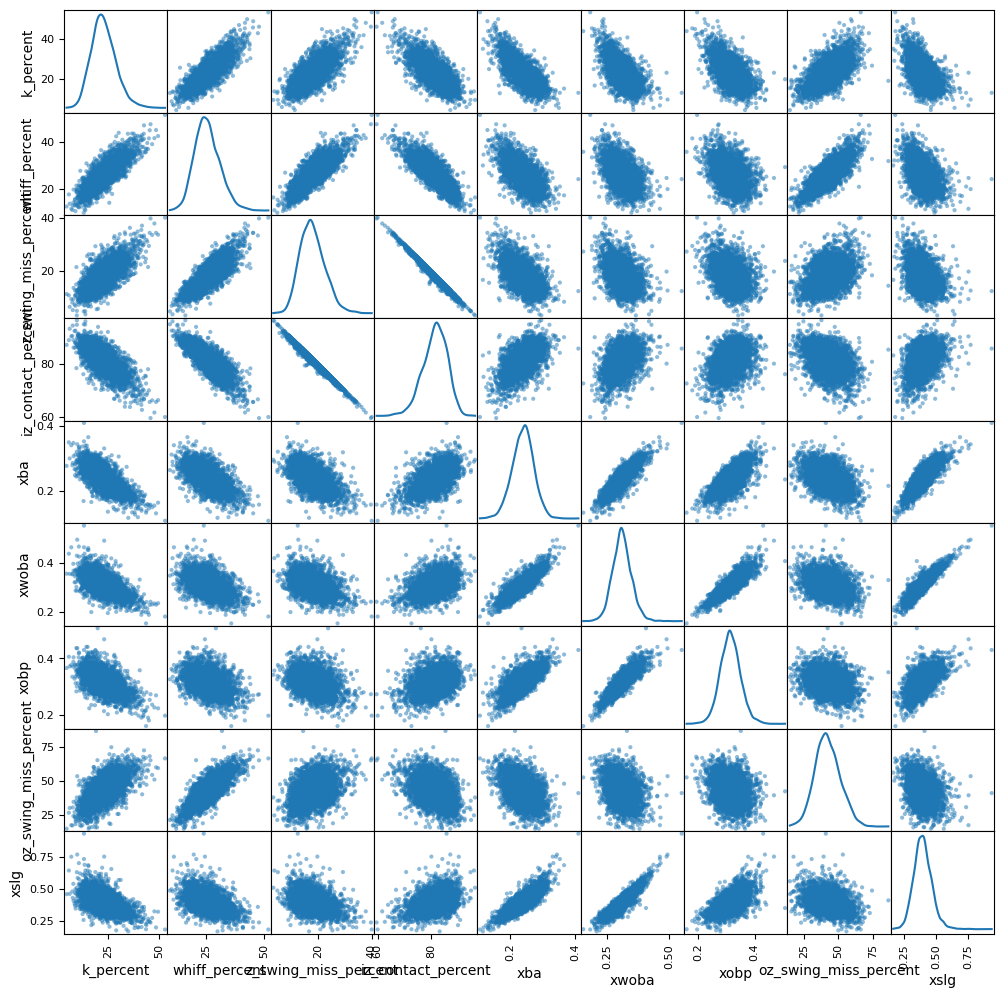

In [9]:
plot_top_x_corr(pitcher_combined, 10, "scatter", "Fpoints_IP")

Many strong correlations throughout, not as many as batting. Normally distributed. 

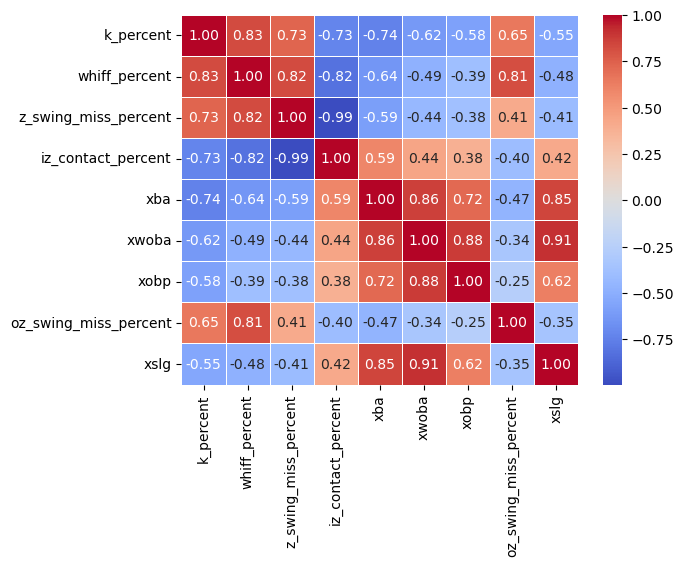

In [10]:
plot_top_x_corr(pitcher_combined, 10, "correlation", "Fpoints_IP")

In [11]:
# Adding columns that represents percentile of fpoints for the year. 
# Calculate the fantasy points from the previous year for each player
pitcher_combined['Fpoints_IP_prev_year'] = pitcher_combined.groupby('Name')['Fpoints_IP'].shift(1)

# Impute missing values in Fpoints_IP_prev_year using IterativeImputer
# Calculate the fantasy points from two previous years for each player
pitcher_combined['Fpoints_IP_two_prev_year'] = pitcher_combined.groupby('Name')['Fpoints_IP'].shift(2)

# Impute missing values in Fpoints_IP_prev_year and Fpoints_IP_two_prev_year using IterativeImputer
prev_imputer = IterativeImputer(max_iter = 30)
pitcher_combined[['Fpoints_IP_prev_year', 'Fpoints_IP_two_prev_year']] = prev_imputer.fit_transform(pitcher_combined[['Fpoints_IP_prev_year', 'Fpoints_IP_two_prev_year']])

# Calculate the weighted fantasy points for the last two years
pitcher_combined['Fpoints_IP_weighted'] = 0.7 * pitcher_combined['Fpoints_IP_prev_year'] + 0.3 * pitcher_combined['Fpoints_IP_two_prev_year']

fpoints2024 = pitcher_combined[pitcher_combined['year'] == 2024][["Name", "Fpoints_IP", "Fpoints_IP_prev_year", "Fpoints_IP_two_prev_year"]]

pitcher_combined['Fpoints_IP_percentile'] = pitcher_combined.groupby('year')['Fpoints_IP_prev_year'].rank(pct = True).drop(columns = ["Fpoints_IP_prev_year", "Fpoints_IP_two_prev_year", "Fpoints_IP_weighted"])
pitcher_combined["Fpoints_IP_percentile"].unique().size


2536

In [12]:
# K%-BB%
pitcher_combined['KpBB%'] = pitcher_combined['k_percent'] / pitcher_combined['bb_percent']

Some very strong positive and negative correlations here. Will need to be addressed in feature selection

## Train-test split

In [13]:
X = pitcher_combined.drop(columns = ['Fpoints_IP'])
y = pitcher_combined['Fpoints_IP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


na_ratio = X_train.isna().any(axis=1).mean()
print(f"Ratio of rows with NAs: {na_ratio:.2%}")

na_columns = X_train.columns[X_train.isna().any()].tolist()
print(f"Columns with NAs: {na_columns}")

X_train.head()

Ratio of rows with NAs: 13.16%
Columns with NAs: ['n_breaking_formatted', 'breaking_avg_speed', 'breaking_avg_spin', 'breaking_avg_break_x', 'breaking_avg_break_z', 'breaking_avg_break_z_induced', 'breaking_avg_break', 'breaking_range_speed', 'n_offspeed_formatted', 'offspeed_avg_speed', 'offspeed_avg_spin', 'offspeed_avg_break_x', 'offspeed_avg_break_z', 'offspeed_avg_break_z_induced', 'offspeed_avg_break']


Name  year  age  k_percent  bb_percent    xba   xslg   woba  \
433     Matt Belisle  2017   37       17.2         3.8  0.276  0.391  0.259   
1569  Daniel Mengden  2019   26       15.1         5.5  0.281  0.494  0.300   
371     Héctor Neris  2016   27       24.1         5.9  0.220  0.416  0.334   
3149     Pablo López  2023   27       23.6         7.2  0.239  0.377  0.305   
2298  Rafael Montero  2021   30       26.4         8.3  0.241  0.475  0.283   

      xwoba   xobp  ...  offspeed_avg_spin  offspeed_avg_break_x  \
433   0.298  0.309  ...             1728.0                  -6.7   
1569  0.352  0.325  ...             1901.0                 -16.2   
371   0.307  0.285  ...             1341.0                 -11.1   
3149  0.301  0.302  ...             1965.0                 -17.3   
2298  0.339  0.317  ...             2067.0                 -15.5   

      offspeed_avg_break_z  offspeed_avg_break_z_induced  offspeed_avg_break  \
433                  -30.7                           5.2                 9.1   
1569                 -33.0                           8.1                18.3   
371                  -38.4                          -0.6                11.9   
3149                 -32.3                           3.5                17.8   
2298                 -28.5                           5.9                16.7   

      Fpoints_IP_prev_year  Fpoints_IP_two_prev_year  Fpoints_IP_weighted  \
433               2.217391                  1.949663             2.137073   
1569              1.602431                  1.930233             1.700771   
371               1.763536                  1.805547             1.776140   
3149              1.966667                  2.315068             2.071187   
2298              2.127907                  0.983193             1.784493   

      Fpoints_IP_percentile     KpBB%  
433                0.863636  4.526316  
1569               0.274336  2.745455  
371                0.504651  4.084746  
3149               0.654267  3.277778  
2298               0.705026  3.180723  

[5 rows x 67 columns]

NA values are only present in breaking balls / offspeed. Since not every pitcher throws them. Will impute these based on other characteristics

In [14]:


# List of columns to drop
columns_to_drop = ['Name']

# Use SimpleImputer instead of IterativeImputer
first_preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('impute', SimpleImputer(strategy='mean'), na_columns),
        ('passthrough_feats', 'passthrough', X_train.columns.drop(columns_to_drop).drop(na_columns))
    ]
)

# Create a pipeline with the updated preprocessor
first_pipeline = Pipeline(steps=[('preprocessor', first_preprocessor)])


# Fit the pipeline on the training data and transform both training and test data
X_train_transformed = first_pipeline.fit_transform(X_train)
X_test_transformed = first_pipeline.transform(X_test)

transformed_features = first_preprocessor.get_feature_names_out()


first_transformed_features = [col.split('__')[-1] for col in transformed_features]
X_train_transformed = pd.DataFrame(X_train_transformed, columns=first_transformed_features, index=X_train.index)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=first_transformed_features, index=X_test.index)

X_train_transformed.head()


n_breaking_formatted  breaking_avg_speed  breaking_avg_spin  \
433                   42.1                84.0             2161.0   
1569                  27.5                78.9             2338.0   
371                   16.9                86.8             1819.0   
3149                   8.1                80.9             2495.0   
2298                   7.3                85.7             2350.0   

      breaking_avg_break_x  breaking_avg_break_z  \
433                    5.9                 -37.9   
1569                   6.6                 -53.3   
371                   -0.3                 -32.8   
3149                  11.0                 -51.7   
2298                   7.6                 -34.9   

      breaking_avg_break_z_induced  breaking_avg_break  breaking_range_speed  \
433                            1.9                 9.3                   5.5   
1569                          -8.1                11.6                   5.9   
371                            4.1                 5.7                   1.6   
3149                          -9.7                14.9                   1.5   
2298                           2.0                 8.7                   1.4   

      n_offspeed_formatted  offspeed_avg_speed  ...  fastball_avg_spin  \
433                    0.9                88.1  ...             2073.0   
1569                  13.0                82.1  ...             2122.0   
371                   25.4                86.0  ...             2317.0   
3149                  35.4                87.5  ...             2174.0   
2298                  20.8                89.1  ...             2261.0   

      fastball_avg_break_x  fastball_avg_break_z  \
433                   -6.6                 -18.0   
1569                  -6.9                 -16.6   
371                  -12.3                 -18.2   
3149                  -4.8                 -20.8   
2298                 -10.9                 -16.8   

      fastball_avg_break_z_induced  fastball_avg_break  Fpoints_IP_prev_year  \
433                           15.2                16.9              2.217391   
1569                          16.1                18.2              1.602431   
371                           13.6                19.1              1.763536   
3149                          11.1                13.2              1.966667   
2298                          13.2                17.7              2.127907   

      Fpoints_IP_two_prev_year  Fpoints_IP_weighted  Fpoints_IP_percentile  \
433                   1.949663             2.137073               0.863636   
1569                  1.930233             1.700771               0.274336   
371                   1.805547             1.776140               0.504651   
3149                  2.315068             2.071187               0.654267   
2298                  0.983193             1.784493               0.705026   

         KpBB%  
433   4.526316  
1569  2.745455  
371   4.084746  
3149  3.277778  
2298  3.180723  

[5 rows x 66 columns]

## Feature Engineering

In [15]:
def calculate_yearly_averages(df, year_col='year'):
    # Group by year, then calculate the mean for each group
    yearly_averages = df.groupby(year_col).mean().reset_index()
    # Rename columns to indicate they are yearly averages
    yearly_averages.columns = [f"{col}_yearly_avg" if col != year_col else col for col in yearly_averages.columns]
    
    return yearly_averages

# Calculate yearly averages for the pitcher_combined dataframe
yearly_averages = calculate_yearly_averages(X_train_transformed)
yearly_averages.head()
# Merge the yearly averages with the training data
X_train_transformed_with_averages = X_train_transformed.merge(yearly_averages, on='year', how='left')

# Merge the yearly averages with the test data
X_test_transformed_with_averages = X_test_transformed.merge(yearly_averages, on='year', how='left')

# Drop year column as we dont need it anymore
X_train_transformed_with_averages = X_train_transformed_with_averages.drop(columns='year')
X_test_transformed_with_averages = X_test_transformed_with_averages.drop(columns='year')

X_train_transformed_with_averages.head()

n_breaking_formatted  breaking_avg_speed  breaking_avg_spin  \
0                  42.1                84.0             2161.0   
1                  27.5                78.9             2338.0   
2                  16.9                86.8             1819.0   
3                   8.1                80.9             2495.0   
4                   7.3                85.7             2350.0   

   breaking_avg_break_x  breaking_avg_break_z  breaking_avg_break_z_induced  \
0                   5.9                 -37.9                           1.9   
1                   6.6                 -53.3                          -8.1   
2                  -0.3                 -32.8                           4.1   
3                  11.0                 -51.7                          -9.7   
4                   7.6                 -34.9                           2.0   

   breaking_avg_break  breaking_range_speed  n_offspeed_formatted  \
0                 9.3                   5.5                   0.9   
1                11.6                   5.9                  13.0   
2                 5.7                   1.6                  25.4   
3                14.9                   1.5                  35.4   
4                 8.7                   1.4                  20.8   

   offspeed_avg_speed  ...  fastball_avg_spin_yearly_avg  \
0                88.1  ...                   2233.562147   
1                82.1  ...                   2237.064607   
2                86.0  ...                   2206.472393   
3                87.5  ...                   2257.233696   
4                89.1  ...                   2280.372881   

   fastball_avg_break_x_yearly_avg  fastball_avg_break_z_yearly_avg  \
0                        -3.022881                       -19.073164   
1                        -3.790169                       -19.308989   
2                        -2.519939                       -19.271472   
3                        -3.776902                       -18.345924   
4                        -3.421695                       -18.792881   

   fastball_avg_break_z_induced_yearly_avg  fastball_avg_break_yearly_avg  \
0                                13.211017                      17.464124   
1                                12.965730                      17.076124   
2                                13.352147                      17.503067   
3                                13.028261                      17.375000   
4                                13.166441                      17.037288   

   Fpoints_IP_prev_year_yearly_avg  Fpoints_IP_two_prev_year_yearly_avg  \
0                         1.720567                             1.791903   
1                         1.750492                             1.790202   
2                         1.756510                             1.799862   
3                         1.851546                             1.850647   
4                         1.863709                             1.792691   

   Fpoints_IP_weighted_yearly_avg  Fpoints_IP_percentile_yearly_avg  \
0                        1.741968                          0.500295   
1                        1.762405                          0.496560   
2                        1.769515                          0.500050   
3                        1.851276                          0.517580   
4                        1.842403                          0.515644   

   KpBB%_yearly_avg  
0          2.953357  
1          2.953547  
2          2.952231  
3          3.170665  
4          3.160733  

[5 rows x 130 columns]

## Data is normally distributed (ish) so no need for square/log/root transformations. Sticking to basic operators. 

In [16]:
# import itertools
# import operator
# import numpy as np
# import warnings

# warnings.filterwarnings('ignore')

# # List of non-yearly average features
# def generate_feature_combinations(*datasets):

#     # Assuming all datasets have the same columns
#     combined_dataset = datasets[0].copy()

#     # List of non-yearly average features
#     non_yearly_avg_features = [col for col in combined_dataset.columns if 'yearly_avg' not in col]

#     # List of operations and their symbols
#     operations = ['+', '-', '*']

#     # Generate all combinations of operations for the features
#     combinations = list(itertools.combinations(non_yearly_avg_features, 2))

#     # Apply the operations to the features
#     for symbol in operations:
#         for (feature1, feature2) in combinations:
#             if feature1 != feature2:
#                 new_feature_name = f"{feature1}_{symbol}_{feature2}"
#                 if symbol == '+':
#                     for dataset in datasets:
#                         dataset[new_feature_name] = dataset[feature1] + dataset[feature2]
#                 elif symbol == '-':
#                     for dataset in datasets:
#                         dataset[new_feature_name] = dataset[feature1] - dataset[feature2]
#                 elif symbol == '*':
#                     for dataset in datasets:
#                         dataset[new_feature_name] = dataset[feature1] * dataset[feature2]

#     return datasets

# # Example usage
# X_train_transformed_with_averages, X_test_transformed_with_averages = generate_feature_combinations(X_train_transformed_with_averages, X_test_transformed_with_averages)
# X_train_transformed_with_averages.head()

In [17]:
X_test_transformed_with_averages = X_test_transformed_with_averages.reindex(columns=X_train_transformed_with_averages.columns, fill_value=0)
X_test_transformed_with_averages.head()

n_breaking_formatted  breaking_avg_speed  breaking_avg_spin  \
0                  36.7                81.3             2323.0   
1                  18.0                80.5             2175.0   
2                  43.5                81.7             2481.0   
3                  37.4                78.6             2695.0   
4                  22.8                87.1             2637.0   

   breaking_avg_break_x  breaking_avg_break_z  breaking_avg_break_z_induced  \
0                   8.1                 -51.0                          -8.1   
1                  -4.2                 -50.2                          -6.8   
2                  15.2                 -45.7                          -3.8   
3                  -7.8                 -58.0                         -11.4   
4                  11.4                 -33.7                           2.5   

   breaking_avg_break  breaking_range_speed  n_offspeed_formatted  \
0                13.0                   3.7                   2.8   
1                 9.6                   3.4                  18.8   
2                16.7                   2.2                   8.4   
3                14.1                   1.6                  12.7   
4                12.5                   2.0                  18.4   

   offspeed_avg_speed  ...  fastball_avg_spin_yearly_avg  \
0                87.6  ...                   2229.330532   
1                83.4  ...                   2237.064607   
2                82.9  ...                   2233.562147   
3                84.3  ...                   2229.330532   
4                90.0  ...                   2243.255495   

   fastball_avg_break_x_yearly_avg  fastball_avg_break_z_yearly_avg  \
0                        -3.722969                       -17.934454   
1                        -3.790169                       -19.308989   
2                        -3.022881                       -19.073164   
3                        -3.722969                       -17.934454   
4                        -3.403571                       -18.175275   

   fastball_avg_break_z_induced_yearly_avg  fastball_avg_break_yearly_avg  \
0                                14.338936                      18.577591   
1                                12.965730                      17.076124   
2                                13.211017                      17.464124   
3                                14.338936                      18.577591   
4                                13.394231                      17.271978   

   Fpoints_IP_prev_year_yearly_avg  Fpoints_IP_two_prev_year_yearly_avg  \
0                         1.741797                             1.762042   
1                         1.750492                             1.790202   
2                         1.720567                             1.791903   
3                         1.741797                             1.762042   
4                         1.762998                             1.785215   

   Fpoints_IP_weighted_yearly_avg  Fpoints_IP_percentile_yearly_avg  \
0                        1.747870                          0.505505   
1                        1.762405                          0.496560   
2                        1.741968                          0.500295   
3                        1.747870                          0.505505   
4                        1.769663                          0.497161   

   KpBB%_yearly_avg  
0          2.902407  
1          2.953547  
2          2.953357  
3          2.902407  
4          3.015481  

[5 rows x 130 columns]

In [18]:

numeric_cols = X_train_transformed_with_averages.columns.tolist()

# Update the preprocessor to scale numeric features
preprocessor = ColumnTransformer(
	transformers=[
		('scale', StandardScaler(), numeric_cols)
	]
)

# Update the pipeline with the updated preprocessor
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit the pipeline on the training data and transform both training and test data
X_train_preprocessed = pipeline.fit_transform(X_train_transformed_with_averages)
X_test_preprocessed = pipeline.transform(X_test_transformed_with_averages)

# Convert the preprocessed data back to a DataFrame
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=X_train_transformed_with_averages.columns, index=X_train_transformed_with_averages.index)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=X_test_transformed_with_averages.columns, index=X_test_transformed_with_averages.index)
X_train_preprocessed.shape

(3070, 130)

In [19]:
# from sklearn.feature_selection import SelectKBest, f_regression

# # Select the top 100 features
# selector = SelectKBest(score_func=f_regression, k=100)
# X_train_reduced = selector.fit_transform(X_train_preprocessed, y_train)
# X_test_reduced = selector.transform(X_test_preprocessed)

# # Get the selected feature names
# selected_features = X_train_preprocessed.columns[selector.get_support()]

# # Convert the reduced datasets back to DataFrames
# X_train_reduced = pd.DataFrame(X_train_reduced, columns=selected_features, index=X_train_preprocessed.index)
# X_test_reduced = pd.DataFrame(X_test_reduced, columns=selected_features, index=X_test_preprocessed.index)

# X_train_reduced.head()

In [20]:


warnings.filterwarnings('ignore')



    # Update classifier_params with XGBoost and LightGBM hyperparameters
def tune_and_select_model(X_train, y_train, X_test, y_test):
    # Define feature selectors
    # feature_selectors = {
    #     'pca' : PCA(),
    #     'select_k_best': SelectKBest(score_func=f_regression, k=10),
    #     'select_from_model': SelectFromModel(estimator=RandomForestRegressor())
    # }

    # Define regressors
    regressors = {
        'linear_regression': Lasso(),
        'random_forest': RandomForestRegressor(),
        'gradient_boosting': GradientBoostingRegressor(),
        'svm': SVR(),
        'neural_network': MLPRegressor()
    }

    # Define hyperparameters for feature selectors
    # feature_selector_params = {
    #     'pca__n_components': [10, 25, 50],
    #     'select_k_best__k': [10, 25, 50],
    #     'select_from_model__max_features': [10, 25, 50]
    # }

    # Define hyperparameters for regressors
    regressor_params = {
        'linear_regression__alpha': np.logspace(-4, 2, 50),
        'random_forest__n_estimators': [25, 50, 100, 200],
        'random_forest__max_depth': [2,4,6,10,14,18,25,40],
        'gradient_boosting__n_estimators': [50, 100, 200],
        'svm__C': [0.01, 0.1, 1, 10],
        'neural_network__hidden_layer_sizes': [(50,), (100,), (50, 50)]
    }

    # Create a list to store the results
    results = []

    # Iterate over feature selectors and regressors

    # Add XGBoost and LightGBM to regressors
    regressors.update({
        'xgboost': xgb.XGBRegressor(),
        'lightgbm': lgb.LGBMRegressor(verbose = -1)
    })

    # Update regressor_params with XGBoost and LightGBM hyperparameters
    regressor_params.update({
        'xgboost__n_estimators': [25,50, 100, 200],
        'xgboost__learning_rate': [0.001,0.01, 0.1, 0.2],
        'lightgbm__n_estimators': [25,50, 100, 200],
        'lightgbm__learning_rate': [0.001,0.01, 0.1, 0.2]
    })

    # for fs_name, fs in feature_selectors.items():
    for reg_name, reg in regressors.items():
        # Create a pipeline
        pipeline = Pipeline([
            # (fs_name, fs),
            (reg_name, reg)
        ])

        # Combine hyperparameters
        # params = {**{f'{k}': v for k, v in feature_selector_params.items() if k.startswith(fs_name)},
                    # **{f'{k}': v for k, v in regressor_params.items() if k.startswith(reg_name)}}

        params = {**{f'{k}': v for k, v in regressor_params.items() if k.startswith(reg_name)}}
        
        print(f' Searching {params}')

        # Perform RandomizedSearchCV
        search = RandomizedSearchCV(pipeline, param_distributions=params, n_iter=5, cv=3, random_state=42)
        print("Search complete")
        search.fit(X_train, y_train)
        print("Fit complete")

        # Get the best model
        best_model = search.best_estimator_

        # Make predictions
        y_pred = best_model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        print("results calculated")

        # Store the results
        results.append({
            # 'feature_selector': fs_name,
            'regressor': reg_name,
            'best_params': search.best_params_,
            'mse': mse,
            'rmse': rmse
        })

    # Find the best result
    best_result = min(results, key=lambda x: x['rmse'])

    return best_result, results



# Example usage
# best_result, all_results = tune_and_select_model(X_train_preprocessed, y_train, X_test_preprocessed, y_test)
# print("Best Result:", best_result)
# print("All Results:", all_results)

In [21]:

# with open('models/pitcher_model_feb16_best.pkl', 'wb') as f:
#     pickle.dump(best_result, f)

In [22]:
## MSE with all sum/diff/multiplication features: 0.448
## MSE without: 0.446
## MSE without feature selection at all + previous percentile: 0.2
## MSE with adding fangraphs: 0.507

with open('models/pitcher_model_feb16_best.pkl', 'rb') as f:
    loaded_best_result = pickle.load(f)

loaded_best_result

{'regressor': 'linear_regression',
 'best_params': {'linear_regression__alpha': np.float64(0.012067926406393288)},
 'mse': 0.4467822038589176,
 'rmse': np.float64(0.6684176866742214)}

In [23]:

# Extract the best feature selector, regressor, and parameters
# best_feature_selector_name = loaded_best_result['feature_selector']
best_regressor_name = loaded_best_result['regressor']
best_params = loaded_best_result['best_params']

# Define feature selectors
# feature_selectors = {
#     'pca': PCA(),
#     'select_k_best': SelectKBest(score_func=f_regression),
#     'select_from_model': SelectFromModel(estimator=RandomForestRegressor())
# }

# Define regressors
regressors = {
    'linear_regression': Lasso(),
    'random_forest': RandomForestRegressor(),
    'gradient_boosting': GradientBoostingRegressor(),
    'svm': SVR(),
    'neural_network': MLPRegressor(),
    'xgboost': xgb.XGBRegressor(),
    'lightgbm': lgb.LGBMRegressor()
}

# Create the pipeline with the best feature selector and regressor
best_model = Pipeline([
    # (best_feature_selector_name, feature_selectors[best_feature_selector_name]),
    (best_regressor_name, regressors[best_regressor_name])
])

# Set the best parameters
best_model.set_params(**best_params)
best_model.fit(X_train_preprocessed, y_train)




Pipeline(steps=[('linear_regression',
                 Lasso(alpha=np.float64(0.012067926406393288)))])

In [24]:
# Extract the feature importances from the best model
if hasattr(best_model.named_steps[best_regressor_name], 'feature_importances_'):
    importances = best_model.named_steps[best_regressor_name].feature_importances_
elif hasattr(best_model.named_steps[best_regressor_name], 'coef_'):
    importances = best_model.named_steps[best_regressor_name].coef_
else:
    raise ValueError(f"The model {best_regressor_name} does not have feature importances or coefficients.")

# Create a DataFrame for the feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X_train_preprocessed.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_df.head(10)  # Display the top 10 features

Feature  Importance
16                 k_percent    0.159287
54        fastball_avg_speed    0.064497
61  Fpoints_IP_two_prev_year    0.052084
64                     KpBB%    0.048703
48          f_strike_percent    0.048557
6         breaking_avg_break    0.037339
36      z_swing_miss_percent    0.037164
43             whiff_percent    0.033571
55         fastball_avg_spin    0.027933
10         offspeed_avg_spin    0.019146

In [25]:


# Extract the gradient boosting model from the best_model pipeline
gradient_boosting_model = best_model.named_steps['linear_regression']

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_preprocessed.values,
    feature_names=X_train_preprocessed.columns,
    class_names=['Fpoints_IP'],
    mode='regression'
)

# Select an instance to explain
instance_idx = 90
instance = X_test_preprocessed.iloc[instance_idx].values.reshape(1, -1)

# Generate explanation
explanation = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=gradient_boosting_model.predict
)
# Get the name corresponding to the instance being explained
instance_name = X_test.iloc[instance_idx]['Name']
print(f"Explaining prediction for: {instance_name}")

# Show the explanation
explanation.show_in_notebook(show_table=True)

Explaining prediction for: Mike Wright Jr.


In [26]:
# all_results = pd.DataFrame(all_results).sort_values(by = 'mse')
# all_results

In [27]:
name_split = all_fpoints_24['Name'].str.split(', ', expand=True)

# Combine first and last names in the desired format
all_fpoints_24['Name'] = name_split[1] + ' ' + name_split[0]

fpoints2024 = fpoints2024.merge(all_fpoints_24, on = ["Name", "Fpoints_IP"], how = "outer")
all_fpoints_24[all_fpoints_24["Name"] == "Paul Skenes"]

Name  Fpoints_IP
6044  Paul Skenes    2.894737

In [28]:
## Prediciting for 2025
pitch_mets = pd.read_csv("data/pitcher_metrics.csv")
pitch_mets_2024 = pitch_mets[pitch_mets['year'] == 2024]

pitch_mets_2024["KpBB%"] = pitch_mets_2024["k_percent"] - pitch_mets_2024["bb_percent"]

pitch_mets_2024 = pitch_mets_2024.rename(columns={"last_name, first_name": "Name"})

name_split = pitch_mets_2024['Name'].str.split(', ', expand=True)

# Combine first and last names in the desired format
pitch_mets_2024['Name'] = name_split[1] + ' ' + name_split[0]


pitch_2024 = pitch_mets_2024.merge(fpoints2024, on="Name")



pitch_2024[pitch_2024["Name"] == "Paul Skenes"]


Name  player_id  year  k_percent  bb_percent    xba   xslg   woba  \
615  Paul Skenes     694973  2024       33.1         6.2  0.193  0.297  0.247   

     xwoba   xobp  ...  offspeed_avg_speed  offspeed_avg_spin  \
615  0.248  0.253  ...                87.3             2044.0   

     offspeed_avg_break_x  offspeed_avg_break_z  offspeed_avg_break_z_induced  \
615                 -17.5                 -32.5                           3.5   

     offspeed_avg_break  KpBB%  Fpoints_IP  Fpoints_IP_prev_year  \
615                17.9   26.9    2.894737                   NaN   

     Fpoints_IP_two_prev_year  
615                       NaN  

[1 rows x 67 columns]

In [29]:


print(pitch_2024['Fpoints_IP_prev_year'].isna().sum())
print(pitch_2024['Fpoints_IP_two_prev_year'].isna().sum())

# Impute missing values in Fpoints_IP_prev_year and Fpoints_IP_two_prev_year using IterativeImputer
pitch_2024[['Fpoints_IP_prev_year', 'Fpoints_IP_two_prev_year']] = prev_imputer.transform(pitch_2024[['Fpoints_IP_prev_year', 'Fpoints_IP_two_prev_year']])


# Calculate the weighted fantasy points for the last two years
pitch_2024['Fpoints_IP_weighted'] = 0.7 * pitch_2024['Fpoints_IP_prev_year'] + 0.3 * pitch_2024['Fpoints_IP_two_prev_year']

# Calculate the percentile of the weighted fantasy points for each year
pitch_2024['Fpoints_IP_percentile'] = pitch_2024.groupby('year')['Fpoints_IP_weighted'].rank(pct=True).drop(columns = ["Fpoints_IP_prev_year", "Fpoints_IP_two_prev_year", "Fpoints_IP_weighted"])

pitch_2024['Fpoints_IP_prev_year'].unique().size
pitch_2024.head()

187
187


Name  player_id  year  k_percent  bb_percent    xba   xslg  \
0  Justin Verlander     434378  2024       18.7         6.8  0.234  0.389   
1     Kenley Jansen     445276  2024       28.4         9.2  0.208  0.352   
2      Jesse Chavez     445926  2024       20.8         7.2  0.263  0.411   
3    Charlie Morton     450203  2024       23.8         9.3  0.243  0.402   
4      Max Scherzer     453286  2024       22.6         5.6  0.243  0.399   

    woba  xwoba   xobp  ...  offspeed_avg_break_x  offspeed_avg_break_z  \
0  0.337  0.301  0.297  ...                 -13.4                 -29.2   
1  0.253  0.280  0.285  ...                   NaN                   NaN   
2  0.315  0.318  0.318  ...                 -16.0                 -35.5   
3  0.335  0.326  0.333  ...                 -17.2                 -37.8   
4  0.312  0.304  0.291  ...                 -13.7                 -39.0   

   offspeed_avg_break_z_induced  offspeed_avg_break  KpBB%  Fpoints_IP  \
0                           9.7                16.8   11.9    1.213097   
1                           NaN                 NaN   19.2    2.335793   
2                           2.2                16.3   13.6    1.922345   
3                           0.2                17.3   14.5    1.752271   
4                           1.0                14.0   17.0    1.886311   

   Fpoints_IP_prev_year  Fpoints_IP_two_prev_year  Fpoints_IP_weighted  \
0              2.037631                  2.968610             2.316925   
1              2.072398                  2.531250             2.210054   
2              2.678363                  1.914616             2.449239   
3              1.884120                  1.994186             1.917140   
4              2.178712                  2.772571             2.356870   

   Fpoints_IP_percentile  
0               0.911532  
1               0.878357  
2               0.943128  
3               0.753555  
4               0.925750  

[5 rows x 69 columns]

In [30]:
age_2024 = pd.read_csv("data/pitcher_2024_age.csv")

age_2024 = age_2024.rename(columns = {"last_name, first_name":"Name", "player_age":"age"})

name_split = age_2024['Name'].str.split(', ', expand=True)

# Combine first and last names in the desired format
age_2024['Name'] = name_split[1] + ' ' + name_split[0]

pitch_mets_2024_new = pitch_2024.merge(age_2024, on = ["Name", 'year', 'player_id']).drop(columns = ['player_id'])





In [31]:
import warnings

warnings.filterwarnings('ignore')

# Imputation processing
new_preprocessed_first = first_pipeline.transform(pitch_mets_2024_new)
new_preprocessed_first = pd.DataFrame(new_preprocessed_first, columns=first_transformed_features, index=pitch_mets_2024_new.index)

# Calculate yearly averages for the pitcher_combined dataframe
yearly_averages_new = calculate_yearly_averages(new_preprocessed_first)

# Merge the yearly averages with the training data
yearly_new_prep = new_preprocessed_first.merge(yearly_averages_new, on='year', how='left')

# Drop year column as we dont need it anymore
yearly_new_prep = yearly_new_prep.drop(columns='year')

# print(yearly_new_prep["fastball_avg_break_z_induced"])


# Generate feature combinations

# Reindex to match the training data columns

# print(yearly_new_prep)
new_transformed = pipeline.transform(yearly_new_prep)
print(new_transformed.shape)
new_transformed = pd.DataFrame(new_transformed, columns=numeric_cols, index=yearly_new_prep.index)

# expected_columns = pd.Index(selector.get_feature_names_out())  # or use the columns from the fitting data

# new_selected = new_transformed.reindex(columns=expected_columns, fill_value=0)
# new_selected = pd.DataFrame(new_selected, columns=selected_features, index=new_transformed.index)
# 
# print(new_selected.isna().sum())
# Find the columns that are different between new_transformed and X_train_preprocessed
diff_columns = set(new_transformed.columns).difference(set(X_train_preprocessed.columns))
print(f"Columns in new_transformed but not in X_train_preprocessed: {diff_columns}")

new_preds = best_model.predict(new_transformed)








(633, 130)
Columns in new_transformed but not in X_train_preprocessed: set()


In [32]:
## Combining preds with data:
pitch_2024['proj_fpoints_ip'] = new_preds
pitch_2024[['Name', 'proj_fpoints_ip']].sort_values(by = 'proj_fpoints_ip', ascending = False).head(50)

Name  proj_fpoints_ip
617      Mason Miller         3.568032
237    Devin Williams         3.482823
247       Griffin Jax         3.252180
504   Garrett Crochet         3.153238
464     Dedniel Núñez         3.144172
171        Edwin Díaz         3.140582
196        Josh Hader         3.109232
443       Edwin Uceta         3.098073
29         Chris Sale         3.060001
332    Tony Santillan         3.007756
404  Jeremiah Estrada         2.992541
126       Blake Snell         2.948205
454        Cade Smith         2.945623
283    Drew Rasmussen         2.945431
270      Jeff Hoffman         2.926024
358      Ryan Helsley         2.888970
414      Tarik Skubal         2.875158
54        Yimi García         2.868073
12        Kirby Yates         2.867349
319        Kris Bubic         2.863471
451     Michel Otañez         2.855508
137     Tyler Glasnow         2.853101
51    Aroldis Chapman         2.846918
568      Hunter Bigge         2.839622
177       Matt Strahm         2.837009
481       Ryan Walker         2.826351
16    David Robertson         2.825035
598        Alek Jacob         2.807268
5        Chris Martin         2.796517
308       Jhoan Duran         2.793824
77         Jason Adam         2.788747
615       Paul Skenes         2.758732
286      Tanner Scott         2.748528
312      Andrés Muñoz         2.747012
22      Fernando Cruz         2.741228
309    Emmanuel Clase         2.728586
506      Andrew Nardi         2.709975
484     Robert Garcia         2.707797
407       Keegan Akin         2.706129
298      Reed Garrett         2.690090
409         Dylan Lee         2.686677
524      Kyle Bradish         2.676081
620       Troy Taylor         2.673793
198     Evan Phillips         2.670939
205   Raisel Iglesias         2.665832
199      Jimmy Herget         2.665020
252       Bryan Abreu         2.656991
356      Jake Cousins         2.656690
211          A.J. Puk         2.652446
41         Sonny Gray         2.650854

In [33]:
razz_preds = pd.read_csv("data/razzball_pitch_preds.csv")
razz_preds.head()
print(razz_preds.columns)

Index(['#', 'Name', 'Team', 'POS', 'R/L', 'G', 'GS', 'QS', 'TBF', 'IP', 'W',
       'L', 'SV', 'HLD', 'ERA', 'SIERA', 'WHIP', 'K', 'BB', 'H', 'HBP', 'ER',
       'R', 'HR', 'GB%', 'FB%', 'LD%', 'BABIP', 'RazzID'],
      dtype='object')


In [34]:
# Get the index based on a name input
input_name = "Paul Skenes"
instance_idx = pitch_mets_2024_new[pitch_mets_2024_new['Name'] == input_name].index[0]
instance = new_transformed.iloc[instance_idx].values.reshape(1, -1)

# Generate explanation
explanation = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=gradient_boosting_model.predict
)

# Get the name corresponding to the instance being explained
instance_name = pitch_mets_2024_new.iloc[instance_idx]['Name']
print(f"Explaining prediction for: {instance_name}")

# Show the explanation
explanation.show_in_notebook(show_table=True)

Explaining prediction for: Paul Skenes


In [35]:
whole_df = pitch_2024.merge(razz_preds, on = "Name", how = "left")
whole_df['proj_fpoints_skill'] = whole_df['proj_fpoints_ip'] * whole_df['IP']
whole_df['proj_fpoints'] = whole_df['proj_fpoints_skill'] + 2*whole_df['W'] - 2*whole_df['L'] + 5*whole_df['SV'] + 2*whole_df["HLD"]
final_df=whole_df[["Name", "proj_fpoints_skill", "proj_fpoints"]].sort_values(by = "proj_fpoints", ascending = False).head(50)
final_df["rank"] = final_df["proj_fpoints"].rank(ascending = False)
final_df=final_df.set_index("rank")
final_df

Name  proj_fpoints_skill  proj_fpoints
rank                                                         
1.0            Tarik Skubal          488.489272    495.089272
2.0            Zack Wheeler          478.753577    490.153577
3.0              Chris Sale          462.978117    474.978117
4.0             Blake Snell          454.023525    462.423525
5.0             Cole Ragans          452.843795    460.243795
6.0             Paul Skenes          451.052690    457.652690
7.0           Logan Gilbert          448.017098    454.617098
8.0         Garrett Crochet          442.399291    447.599291
9.0             Dylan Cease          435.089789    443.489789
10.0               Joe Ryan          432.325320    437.325320
11.0          Corbin Burnes          426.019607    435.219607
12.0             Sonny Gray          422.811155    429.811155
13.0            Bailey Ober          423.436986    428.036986
14.0           Michael King          418.454543    425.054543
15.0         Framber Valdez          413.502234    424.302234
16.0      Grayson Rodriguez          406.324529    414.324529
17.0           Tanner Bibee          408.791040    411.791040
18.0         Freddy Peralta          406.539837    411.139837
19.0             Robbie Ray          409.656472    410.856472
20.0             Aaron Nola          401.236911    409.636911
21.0          Justin Steele          401.593463    408.393463
22.0          Hunter Greene          403.803464    407.803464
23.0           George Kirby          400.905087    406.305087
24.0  Spencer Schwellenbach          393.817250    404.617250
25.0     Yoshinobu Yamamoto          393.589773    403.189773
26.0          Luis Castillo          396.720442    401.320442
27.0          Yusei Kikuchi          394.777998    398.777998
28.0         Brandon Pfaadt          383.618085    389.618085
29.0            Gerrit Cole          381.964753    387.564753
30.0            Jared Jones          385.854792    386.854792
31.0              Seth Lugo          381.090152    386.290152
32.0              Max Fried          375.396419    384.396419
33.0          Shota Imanaga          375.738761    381.738761
34.0           Hunter Brown          373.624608    380.624608
35.0            Taj Bradley          376.445694    379.245694
36.0          Tyler Glasnow          369.191218    378.991218
37.0           Bryce Miller          374.538534    377.938534
38.0            Ryan Pepiot          374.096561    375.296561
39.0             Logan Webb          367.262750    374.462750
40.0          Jack Flaherty          368.791556    368.991556
41.0         Nathan Eovaldi          361.739818    367.539818
42.0         Devin Williams          208.621113    366.421113
43.0             Josh Hader          201.478233    359.478233
44.0         Drew Rasmussen          347.855399    359.255399
45.0           Mitch Keller          357.612568    358.212568
46.0         MacKenzie Gore          354.242515    355.242515
47.0         Emmanuel Clase          176.812359    353.212359
48.0           Ronel Blanco          347.975168    352.975168
49.0           Ryan Helsley          173.049305    349.649305
50.0            Sean Manaea          341.636796    349.036796

In [37]:
final_df.to_csv("predictions/initial_picher_preds.csv")